In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.model_selection import KFold

In [2]:
def getAverageReactivies(data, className):
    return np.mean(
        [record[className] for record in data ],
        axis=0
    )

In [3]:
data = [
    json.loads(text)
    for text in open('data/train.json')
    
]
reactClasses = ['reactivity', 'deg_pH10', 'deg_Mg_pH10', 'deg_50C', 'deg_Mg_50C']
averages = {
    className: getAverageReactivies(data, className)
    for className in reactClasses
}
placeHolder = '*'
acceptableBases = ['A', 'G', 'U', 'C', placeHolder]
frameLength = 6
batchSize = 100
folds = 5
epochs = 15
learningRate = 0.0001

### Observation: the beginning and the end of the strands are a little more reactive than the middle, but other than that, the reactivies aren't really a function of their location in the sequence. This is sensible though, because, this sequence may just a subsequence of a larger sequence.

Text(0.5, 1.0, 'Average Reactivies For Each Class')

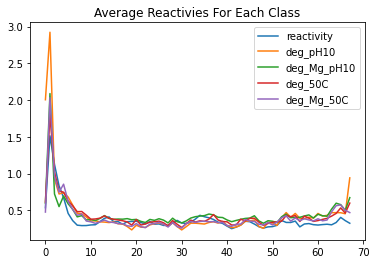

In [4]:
for className in reactClasses:
    plt.plot(averages[className], label=className)
plt.legend()
plt.title('Average Reactivies For Each Class')

In [5]:
def visualizeAverageNBases(reactivityClass):
    reactivitiesByFrame = {}
    for record in data:
        numBases = record['seq_scored']
        sequence = record['sequence']
        frames = getPreviousNBases(sequence[0:numBases])
        reactivities = record[reactivityClass]
        assert len(reactivities) == numBases
        assert len(frames) == numBases
        for i in range(numBases):
            if frames[i] not in reactivitiesByFrame.keys():
                reactivitiesByFrame[frames[i]] = [reactivities[i]]
            else:
                reactivitiesByFrame[frames[i]].append(reactivities[i])
    labels = [frame for frame in reactivitiesByFrame.keys()]
    averages = [ np.mean(reactivitiesByFrame[frame]) for frame in labels ]
    plt.bar(labels, averages)
    plt.title(f'Average reactivity for "{reactivityClass}" grouped by all unique reading frames of length {n}')
    plt.show()

In [6]:
def getPreviousNBases(sequence):
    assert frameLength < len(sequence), 'cannot have framelength greater than sequence length'
    frames = []
    for i in range(len(sequence)):
        if i < frameLength - 1:
            numPadding = frameLength - 1 - i
            frame = ''.join([placeHolder for i in range(numPadding)]) + sequence[0:i+1]
        else:
            frame = sequence[i - frameLength + 1:i + 1]
        frames.append(frame)
    assert len(frames) == len(sequence), f'length of frames is {len(frames)}, length of sequence is {len(sequence)}'
    return frames

    
def buildFeatureSet(frame, index):
    # data validation
    for char in frame:
        assert char in acceptableBases, f'{char} is not an acceptable base'
    
    # feature extraction
    featureSet = []
    for actualBase in frame:
        for possibleBase in acceptableBases:
            if actualBase == possibleBase:
                featureSet.append(1)
            else:
                featureSet.append(0)
    featureSet.append(index)
    return featureSet


def extractFeatureSets(record):
    fullSequence = record['sequence']
    lengthOfData = record['seq_scored']
    partialSeq = fullSequence[:lengthOfData]
    frames = getPreviousNBases(partialSeq)
    return [
        buildFeatureSet(
            frames[i],
            i
        )
        for i in range(len(frames))
    ]


def train(model, optimizer, criteria, trainLoader, valLoader):
    trainLoss = []
    valLoss = []
    for epoch in range(epochs):
        
        # ****** Training *******
        model.train()
        losses = []
        for features, labels in trainLoader:
            optimizer.zero_grad()
            output = model(features)
            loss = criteria(output, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        trainLoss.append(np.mean(losses))
        
        # ****** Validation *******
        model.eval()
        losses = []
        with torch.no_grad():
            for features, labels in valLoader:
                optimizer.zero_grad()
                output = model(features)
                loss = criteria(output, labels)
                losses.append(loss.item())
            valLoss.append(np.mean(losses))
    return trainLoss, valLoss


def getDataSet(indices, className):
    records = [ data[i] for i in indices]
    featureSets = []
    labels = []
    for record in records:
        featureSets += extractFeatureSets(record)
        labels += [[reactivity] for reactivity in record[className]]
    assert len(featureSets) == len(labels), f'length of featureSets: {len(featureSets)}, length of labels: {len(labels)}'
    return RNADataSet(featureSets, labels)

In [7]:
class RNADataSet(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(np.array(features)).float()
        self.labels = torch.from_numpy(np.array(labels)).float()
    
    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [8]:
className = 'reactivity'
splitter = KFold(folds)
allTrainLosses = []
allValLosses = []
foldCounter = 1
print('entering cross validation training')
for trainIndices, valIndices in splitter.split(data):
    trainData = getDataSet(trainIndices, className)
    valData = getDataSet(valIndices, className)
    trainLoader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
    valLoader = DataLoader(valData, batch_size=batchSize, shuffle=True)
    numFeatures = len(trainData[0][0])
    model = torch.nn.Linear(numFeatures, 1)
    criteria = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    trainLosses, valLosses = train(model, optimizer, criteria, trainLoader, valLoader)
    allTrainLosses.append(trainLosses)
    allValLosses.append(valLosses)
    print(f'Fold {foldCounter} last-epoch training: {round(trainLosses[-1], 4)}, validation: {round(valLosses[-1], 4)}')
    foldCounter += 1

entering cross validation training


/home/abeeston/.local/share/virtualenvs/dataScience-GZHB9V2k/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Fold 1 last-epoch training: 0.4868, validation: 0.4557
Fold 2 last-epoch training: 0.4762, validation: 0.4975
Fold 3 last-epoch training: 0.502, validation: 0.4053
Fold 4 last-epoch training: 0.4896, validation: 0.4642
Fold 5 last-epoch training: 0.452, validation: 0.619


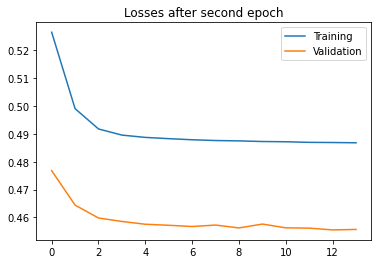

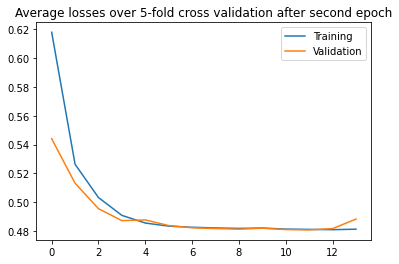

Final average training loss: 0.4813
Final average validation loss: 0.4883


In [9]:
# print(allTrainLosses)
# print(allValLosses)
startingEpoch = 1

plt.title('Losses after second epoch')
plt.plot(allTrainLosses[0][startingEpoch:], label='Training')
plt.plot(allValLosses[0][startingEpoch:], label='Validation')
plt.legend()
plt.show()

averageTrainLosses = []
averageValLosses = []
for i in range(epochs)[startingEpoch:]:
    averageTrainLosses.append(np.mean([loss[i] for loss in allTrainLosses]))
    averageValLosses.append(np.mean([loss[i] for loss in allValLosses]))
plt.plot(averageTrainLosses, label='Training')
plt.plot(averageValLosses, label='Validation')
plt.title(f'Average losses over {folds}-fold cross validation after second epoch')
plt.legend()
plt.show()
print(f'Final average training loss: {round(averageTrainLosses[-1], 4)}')
print(f'Final average validation loss: {round(averageValLosses[-1], 4)}')